In [1]:
# set environment 
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import exp
from pyspark.sql.functions import max,sum,count
from pyspark.ml.classification import LogisticRegression  
import matplotlib.pyplot as plt
import numpy as np
spark = SparkSession.builder.appName('Bank Telephone Marketing Analysis step1-7').getOrCreate() 

In [2]:
#read data
df = spark.read.csv("bank-additional-full.csv",inferSchema=True,header=True,sep=";")

In [3]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [4]:
import pandas as pd 

In [5]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934045,17,98
job,41188,None,None,admin.,unknown
marital,41188,None,None,divorced,unknown
education,41188,None,None,basic.4y,unknown
default,41188,None,None,no,yes
housing,41188,None,None,no,yes
loan,41188,None,None,no,yes
contact,41188,None,None,cellular,telephone
month,41188,None,None,apr,sep


In [6]:
#split data by y,
DataY=df.filter("y='yes'") 
DataN=df.filter("y='no'") 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def ShowGroupAndY2_new(fields):
    for field in fields:
        ages_df=df.groupby(df[field].alias("age")).agg(count("y").alias("count_all")).sort("age")
        ages_dfY=DataY.groupby(DataY[field].alias("age")).agg(count("y").alias("count_y")).sort("age")
        ages_dfN=DataN.groupby(DataN[field].alias("age")).agg(count("y").alias("count_n")).sort("age")
        ages_df=ages_df.join(ages_dfY,on=['age'],how='left')
        ages_df=ages_df.join(ages_dfN,on=['age'],how='left')
        ages_df=ages_df.na.fill(0).toPandas()
        ages = ages_df["age"].values.tolist()
        ages_df["ageY"]=ages_df.count_y*100/ages_df.count_all        
        ages_df["ageN"]=ages_df.count_n*100/ages_df.count_all
#ages=ages[0:10]
        N = len(ages) 
        AgeY = ages_df["ageY"].values.tolist()
        AgeN = ages_df["ageN"].values.tolist()
        ind = np.arange(N)    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence
       # AgeFull = [  100 for age in ages]
#print(AgeY)
#print(AgeN)
        p1 = plt.bar(ind, AgeN, width )
        p2 = plt.bar(ind, AgeY, width ,
             bottom=AgeN)

        plt.ylabel('count(*)')
        plt.title('count by group by '+field)
        if(len(ages)>20):
           # ind = np.arange(int(N/10))    # the x locations for the groups
           # print(ind)
            gap=10;
            if len(ages)>3000:
                gap=1000
            elif len(ages)>300:
                gap=100
            else:
                gap=10 
            xti_ages=[ ages[i] if (i%gap==0) else "" for i in ind]
            plt.xticks(ind, xti_ages , rotation='vertical' )
            #xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )
        elif len(ages)>5:
            plt.xticks(ind, ages, rotation='vertical')
        else:
            plt.xticks(ind, ages )
        plt.yticks(np.arange(0, 100, 10))
        plt.legend((p1[0], p2[0]), ('No', 'Yes'))
        plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def ShowGroupAndY2(fields):
    for field in fields:
        ages = sorted(df.select(df[field]).distinct().toPandas()[field])
        N = len(ages)
        ind = np.arange(N)    # the x locations for the groups
        if(N>0):         
            gap=10;
            if N>3000:
                gap=1000
            elif N>300:
                gap=100
            elif N>20:
                gap=10 
            else:
                gap=1
            MinAges=[ ages[i]   for i in ind if (i%gap==0)]              
            iMinAge=len(MinAges)
            AgeN = [DataN.filter((DataN[field]>=MinAges[i]) & (DataN[field]<MinAges[i+1])).count()*100/df.filter((df[field]>=MinAges[i]) & (df[field]<MinAges[i+1])).count() for i in np.arange(iMinAge-1)] 
            AgeY = [DataY.filter((DataY[field]>=MinAges[i]) & (DataY[field]<MinAges[i+1])).count()*100/df.filter((df[field]>=MinAges[i]) & (df[field]<MinAges[i+1])).count() for i in np.arange(iMinAge-1)]
            AgeN.append(DataN.filter(DataN[field]>=MinAges[iMinAge-1]).count()*100/df.filter(df[field]>=MinAges[iMinAge-1]).count())
            AgeY.append(DataY.filter(DataY[field]>=MinAges[iMinAge-1]).count()*100/df.filter(df[field]>=MinAges[iMinAge-1]).count())
            #if not (N%gap==0):            #    MinAges.append(ages[N-1])            #    AgeN.append(0)            #    AgeY.append(0)
            N=len(MinAges)
        ind = np.arange(N)    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence    
        p1 = plt.bar(ind, AgeN, width )
        p2 = plt.bar(ind, AgeY, width ,
             bottom=AgeN)

        plt.ylabel('count(*)')
        plt.title('count by group by '+field)
        if len(MinAges)>5:
            plt.xticks(ind, MinAges, rotation='vertical')
        else:
            plt.xticks(ind, MinAges )
        plt.yticks(np.arange(0, 100, 10))
        plt.legend((p1[0], p2[0]), ('No', 'Yes'))
        plt.show()

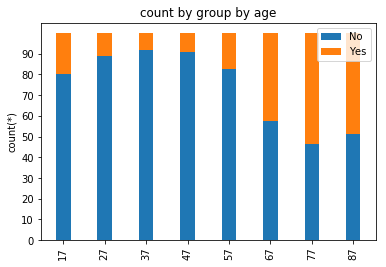

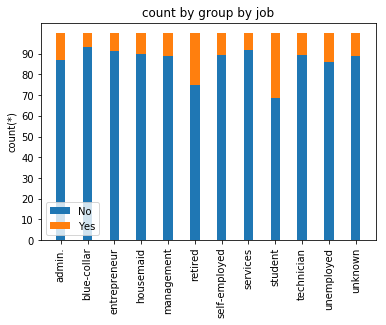

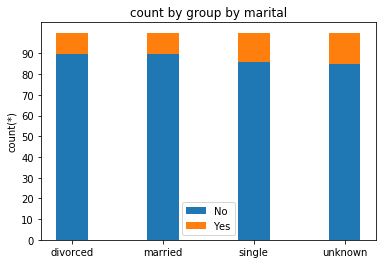

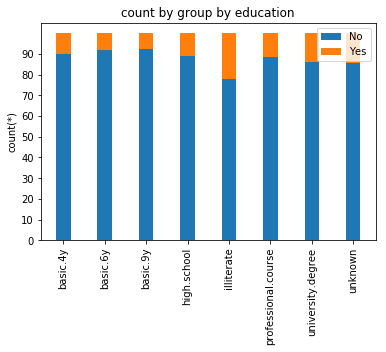

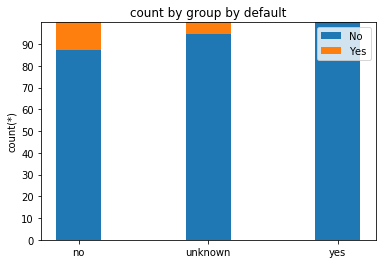

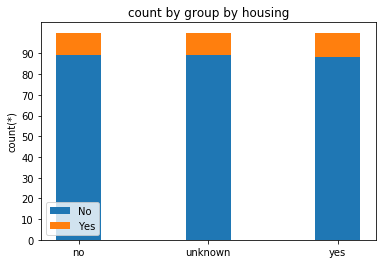

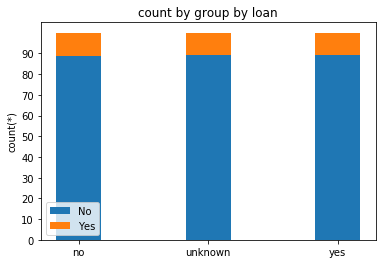

In [9]:
ShowGroupAndY2(['age','job','marital','education','default','housing','loan'])

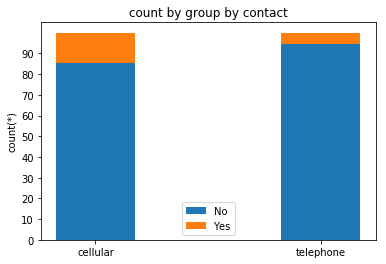

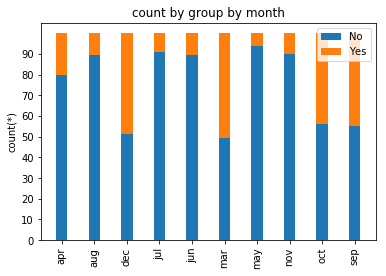

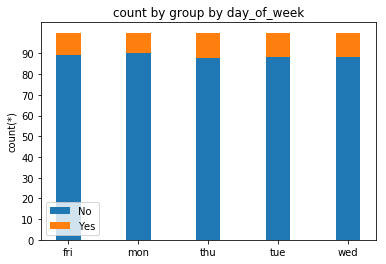

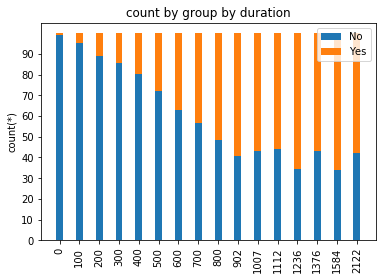

In [10]:
ShowGroupAndY2(['contact','month','day_of_week','duration'])

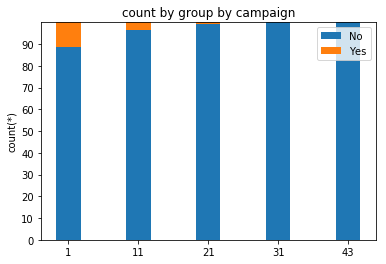

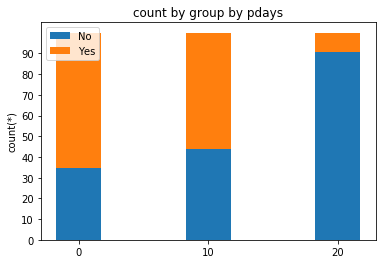

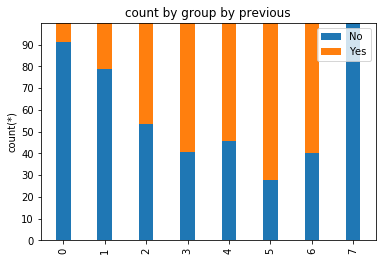

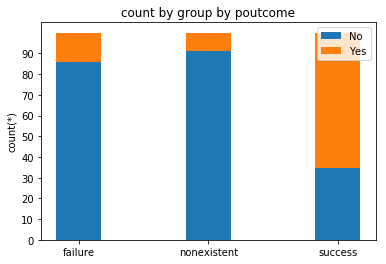

In [11]:
ShowGroupAndY2(['campaign','pdays','previous','poutcome'])

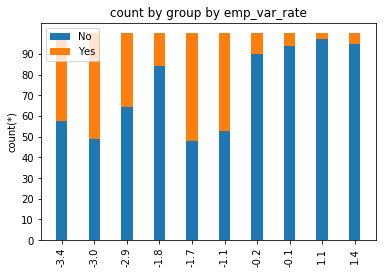

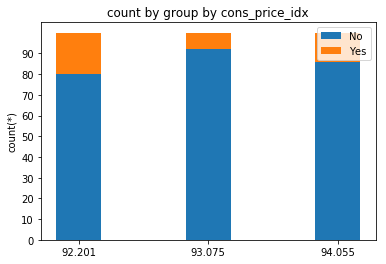

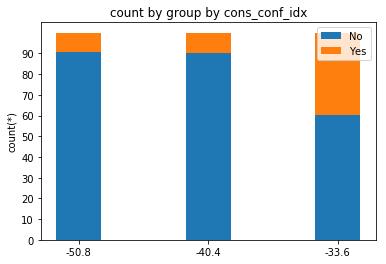

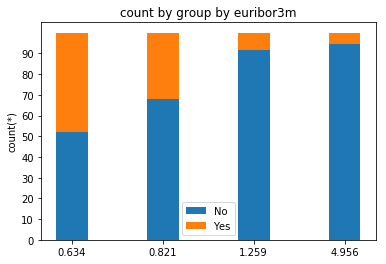

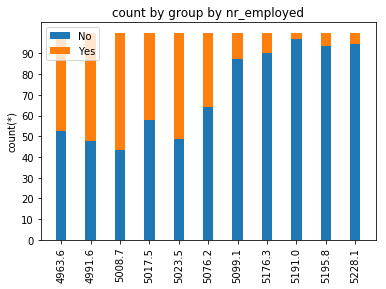

In [12]:
ShowGroupAndY2(['emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed']) 

In [13]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [14]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934045,17,98
duration,41188,258.2850101971448,259.2792488364655,0,4918
campaign,41188,2.567592502670681,2.770013542902322,1,56
pdays,41188,962.4754540157328,186.91090734474153,0,999
previous,41188,0.17296299893172767,0.49490107983929055,0,7
emp_var_rate,41188,0.0818855006319146,1.5709597405170326,-3.4,1.4
cons_price_idx,41188,93.57566436831263,0.5788400489540964,92.201,94.767
cons_conf_idx,41188,-40.50260027191399,4.628197856174574,-50.8,-26.9
euribor3m,41188,3.621290812858068,1.7344474048512526,0.634,5.045


/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


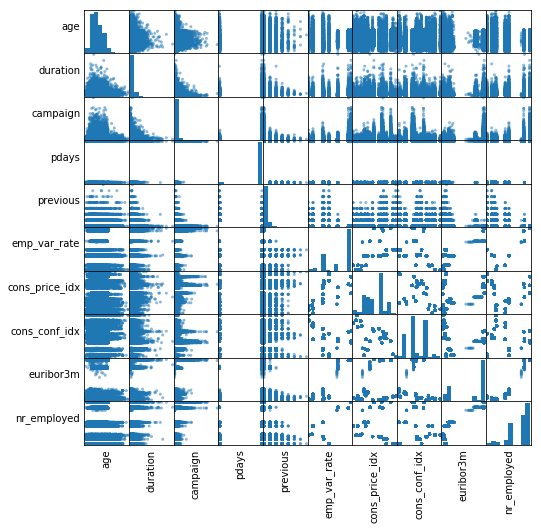

In [15]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [16]:
df.groupby('job').agg({"age":"avg","age":"max","age":"count"}).show()

+-------------+----------+
|          job|count(age)|
+-------------+----------+
|   management|      2924|
|      retired|      1720|
|      unknown|       330|
|self-employed|      1421|
|      student|       875|
|  blue-collar|      9254|
| entrepreneur|      1456|
|       admin.|     10422|
|   technician|      6743|
|     services|      3969|
|    housemaid|      1060|
|   unemployed|      1014|
+-------------+----------+



In [17]:
df.groupby('job').agg({"age":"avg","age":"min"}).show()

+-------------+--------+
|          job|min(age)|
+-------------+--------+
|   management|      21|
|      retired|      23|
|      unknown|      24|
|self-employed|      21|
|      student|      17|
|  blue-collar|      20|
| entrepreneur|      20|
|       admin.|      20|
|   technician|      20|
|     services|      20|
|    housemaid|      21|
|   unemployed|      21|
+-------------+--------+



In [18]:


df_group = df.select('*', (df.age ).alias('age1'))
df_group.groupby("job").agg({"age":"min","age1":"max","y":"count"}).show()

+-------------+--------+--------+---------+
|          job|count(y)|min(age)|max(age1)|
+-------------+--------+--------+---------+
|   management|    2924|      21|       80|
|      retired|    1720|      23|       98|
|      unknown|     330|      24|       81|
|self-employed|    1421|      21|       71|
|      student|     875|      17|       47|
|  blue-collar|    9254|      20|       80|
| entrepreneur|    1456|      20|       69|
|       admin.|   10422|      20|       72|
|   technician|    6743|      20|       70|
|     services|    3969|      20|       69|
|    housemaid|    1060|      21|       85|
|   unemployed|    1014|      21|       66|
+-------------+--------+--------+---------+



In [19]:

df_group.groupby("marital").agg({"age":"min","age1":"max","y":"count"}).show()

+--------+--------+--------+---------+
| marital|count(y)|min(age)|max(age1)|
+--------+--------+--------+---------+
| unknown|      80|      25|       66|
|divorced|    4612|      24|       95|
| married|   24928|      20|       98|
|  single|   11568|      17|       86|
+--------+--------+--------+---------+



In [20]:

df_group.groupby("education").agg({"age":"min","age1":"max","y":"count"}).show()

+-------------------+--------+--------+---------+
|          education|count(y)|min(age)|max(age1)|
+-------------------+--------+--------+---------+
|        high.school|    9515|      18|       88|
|            unknown|    1731|      17|       92|
|           basic.6y|    2292|      18|       95|
|professional.course|    5243|      20|       86|
|  university.degree|   12168|      20|       91|
|         illiterate|      18|      34|       80|
|           basic.4y|    4176|      18|       98|
|           basic.9y|    6045|      17|       94|
+-------------------+--------+--------+---------+



In [6]:
def del_unknown(data):
    # fill_attrs = ["default"]
    del_attrs = ['job','marital','education','housing','loan']
    for i in del_attrs: 
        # delete col containing unknown
        data = data[data[i] != "unknown"]  
    return data

In [7]:
#delete unknown data
df=del_unknown(df)

In [8]:
#convert 'admin.' to 'admin' by add a new field
from pyspark.sql.functions import col, when

valueWhenTrue = "admin"  # for example

df=df.withColumn(
    "job_new",
    when(
        col("job") == "admin.",
        valueWhenTrue
    ).otherwise(col("job"))
)

In [9]:
df.groupby("job_new").agg({"y":"count"}).show()

+-------------+--------+
|      job_new|count(y)|
+-------------+--------+
|   management|    2728|
|      retired|    1577|
|self-employed|    1349|
|      student|     688|
|  blue-collar|    8560|
| entrepreneur|    1360|
|   technician|    6380|
|        admin|    9937|
|     services|    3716|
|    housemaid|     987|
|   unemployed|     963|
+-------------+--------+



In [10]:
#discard  age <=50 and job='retired'
df=df.filter((df['age']>50) |(df['job']!='retired'))

In [11]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,38131,39.85025307492592,10.298119756703919,17,98
job,38131,None,None,admin.,unemployed
marital,38131,None,None,divorced,single
education,38131,None,None,basic.4y,university.degree
default,38131,None,None,no,yes
housing,38131,None,None,no,yes
loan,38131,None,None,no,yes
contact,38131,None,None,cellular,telephone
month,38131,None,None,apr,sep


In [12]:
#add an ID field
from pyspark.sql.functions import monotonically_increasing_id 

df = df.select("*").withColumn("id", monotonically_increasing_id())

In [13]:
df.groupby("education").agg({"age":"count"}).show()

+-------------------+----------+
|          education|count(age)|
+-------------------+----------+
|        high.school|      9227|
|           basic.6y|      2194|
|professional.course|      5088|
|  university.degree|     11813|
|         illiterate|        16|
|           basic.4y|      3962|
|           basic.9y|      5831|
+-------------------+----------+



In [14]:
#convert education field
from pyspark.sql.functions import udf 
dicEducation={'illiterate':0,'basic.4y':1,'basic.6y':1,'basic.9y':2,
                                'high.school' :2, 'professional.course' :3, 
                                'university.degree' :3}
def SimpleEducation(oldEducation):
    return dicEducation[oldEducation] 

from pyspark.sql.types import IntegerType
square_udf_education = udf(lambda z: SimpleEducation(z), IntegerType())
df = df.select("*").withColumn("education_new", square_udf_education(df["education"]))

In [15]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [16]:
#format data 'default','housing','loan','job_new','contact','month','day_of_week','poutcome','marital'
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

indexers = [StringIndexer(inputCol=column, outputCol=   "d_"+column).fit(df) for column in
                    ['default','housing','loan','job_new','contact','month','day_of_week','poutcome','marital']]


pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [17]:
#format data 'd_job_new','d_marital','d_poutcome' 
job_encoder = OneHotEncoder(inputCol='d_job_new',outputCol='jobVec')
marital_encoder = OneHotEncoder(inputCol='d_marital',outputCol='maritalVec')   
poutcome_encoder = OneHotEncoder(inputCol='d_poutcome',outputCol='poutcomeVec')
stages=[job_encoder,marital_encoder,poutcome_encoder]
pipeline = Pipeline(stages=stages)
df = pipeline.fit(df).transform(df)

In [18]:
# convert "yes" to 1 and "no" to 0 by add new field d_y
df=df.withColumn(
    "d_y",
    when(
        col("y") == "yes",
        1
    ).otherwise(0)
)

In [19]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- job_new: string (nullable = true)
 |-- id: long (nullable = false)
 |-- education_new: integer (nullable = true)
 |-- d_default: double (nullable = true)

In [20]:
#reduce fields
df=df.drop("job_new").drop("job").drop("marital").drop("education").drop("default").drop("housing").drop("loan")
df=df.drop("contact").drop("month").drop("day_of_week").drop("poutcome") 

In [21]:
df=df.drop("d_housing").drop("d_day_of_week").drop("d_loan") 

In [22]:
#generate features field
from pyspark.ml.feature import VectorAssembler 
assemblerInputs = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate'
              ,'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'education_new', 'd_default'
              ,'jobVec', 'd_contact', 'd_month', 'poutcomeVec', 'maritalVec' ]  
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df = assembler.transform(df)

In [23]:
#get field position and fieldName in feature column
fields=[x["name"] for x in sorted(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+df.schema["features"].metadata["ml_attr"]["attrs"]["nominal"], 
   key=lambda x: x["idx"])]

In [24]:
#split train and test data
train, test = df.randomSplit([0.9, 0.1], seed = 1234)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 34244
Test Dataset Count: 3887


In [25]:
df.groupby("d_y").agg({"age":"count"}).show()

+---+----------+
|d_y|count(age)|
+---+----------+
|  1|      4250|
|  0|     33881|
+---+----------+



In [26]:
df.show(1)

+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---+-------------+---------+---------+---------+-------+----------+---------+--------------+-------------+-------------+---+--------------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| id|education_new|d_default|d_job_new|d_contact|d_month|d_poutcome|d_marital|        jobVec|   maritalVec|  poutcomeVec|d_y|            features|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---+-------------+---------+---------+---------+-------+----------+---------+--------------+-------------+-------------+---+--------------------+
| 56|     261|       1|  999|       0|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|  0|            1|      0.0|      8.0|      1.0|    0.0|       0.0|      0.0|(10,[8],[1.0])|(2,[0],[1.0])|(2,[0],[1.0])|  0|(28,[0,1,2,3,5

In [27]:
train.groupby("d_y").agg({"age":"count"}).show()

+---+----------+
|d_y|count(age)|
+---+----------+
|  1|      3815|
|  0|     30429|
+---+----------+



In [28]:
#balance train data
trainY=train.filter("d_y=1").count()*1.0
trainN=train.filter("d_y=0").count()*1.0
train = train.sampleBy('d_y', fractions={0: trainY/trainN, 1: 1.0}).cache()


In [29]:
train.groupby("d_y").agg({"age":"count"}).show()

+---+----------+
|d_y|count(age)|
+---+----------+
|  1|      3815|
|  0|      3809|
+---+----------+



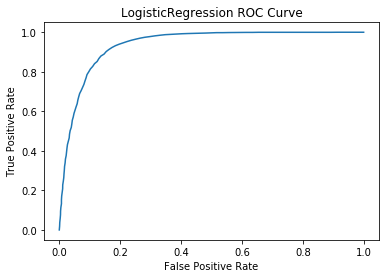

Area Under the Curve: 0.9371360804670059
LogisticRegression accuracy: 0.8590172369436584
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               375.0|
|        0|       3452|               488.0|
+---------+-----------+--------------------+



In [30]:
# try LogisticRegression
from pyspark.sql.functions import max,sum,count
from pyspark.ml.classification import LogisticRegression  
import matplotlib.pyplot as plt
import numpy as np
# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='d_y') 
# Fit the model.
lr_model = lr_model.fit(train) 
# And evaluate the model using the test data.
lr_result = lr_model.transform(test)
# Let's get a summary of the data.
training_summary = lr_model.summary 
ROC = training_summary.roc.toPandas() 
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('LogisticRegression ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_result)

print('LogisticRegression accuracy: ' + str(lr_accuracy))

lr_result.groupBy(lr_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

In [31]:
# try DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
 
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="d_y", featuresCol="features")
 # Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[ dt])

# Train model.  This also runs the indexers.
dt_model = pipeline.fit(train) 

# Make predictions.
dt_result = dt_model.transform(test) 
 
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_result)

print('DecisionTree accuracy: ' + str(dt_accuracy))
dt_result.groupBy(dt_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

DecisionTree accuracy: 0.8484692564960123
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               382.0|
|        0|       3452|               536.0|
+---------+-----------+--------------------+



In [32]:
#try DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="d_y", featuresCol="features", numTrees=10)  
# Train model.  This also runs the indexers.
rf_model = rf.fit(train) 
# Make predictions.
rf_result = rf_model.transform(test)
# Select example rows to display.
rf_result.select("prediction", "d_y", "features").show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_result)

print('RandomForest accuracy: ' + str(rf_accuracy))
rf_result.groupBy(rf_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()


+----------+---+--------------------+
|prediction|d_y|            features|
+----------+---+--------------------+
|       1.0|  0|(28,[0,1,2,3,4,5,...|
|       0.0|  0|(28,[0,1,2,3,5,6,...|
|       0.0|  0|(28,[0,1,2,3,5,6,...|
|       1.0|  0|(28,[0,1,2,3,4,5,...|
|       1.0|  0|(28,[0,1,2,3,4,5,...|
+----------+---+--------------------+
only showing top 5 rows

RandomForest accuracy: 0.8096218163107796
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               397.0|
|        0|       3452|               702.0|
+---------+-----------+--------------------+



In [33]:
# try GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a GBT model.
gbt = GBTClassifier(labelCol="d_y", featuresCol="features", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[ gbt])

# Train model.  This also runs the indexers.
gbt_model = pipeline.fit(train)

# Make predictions.
gbt_result = gbt_model.transform(test)

# Select example rows to display.
gbt_result.select("prediction", "d_y", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = evaluator.evaluate(gbt_result) 
print('GBTClassifier accuracy: ' + str(gbt_accuracy))
gbt_result.groupBy(gbt_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()


+----------+---+--------------------+
|prediction|d_y|            features|
+----------+---+--------------------+
|       1.0|  0|(28,[0,1,2,3,4,5,...|
|       0.0|  0|(28,[0,1,2,3,5,6,...|
|       0.0|  0|(28,[0,1,2,3,5,6,...|
|       1.0|  0|(28,[0,1,2,3,4,5,...|
|       1.0|  0|(28,[0,1,2,3,4,5,...|
+----------+---+--------------------+
only showing top 5 rows

GBTClassifier accuracy: 0.853357344996141
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               392.0|
|        0|       3452|               527.0|
+---------+-----------+--------------------+



In [30]:
# try different parameters in DecisionTree
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.sql.functions import max,sum,count
 

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="d_y", featuresCol="features",maxDepth=3, maxBins=32)
 # Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[ dt])

# Train model.  This also runs the indexers.
dt_model = pipeline.fit(train) 

# Make predictions.
dt_result = dt_model.transform(test) 
 
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_result)

print('DecisionTree accuracy: ' + str(dt_accuracy))
dt_result.groupBy(dt_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

DecisionTree accuracy: 0.8085927450475946
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               390.0|
|        0|       3452|               699.0|
+---------+-----------+--------------------+



In [31]:
 
# try different parameters in LogisticRegression
from pyspark.sql.functions import max,sum,count
from pyspark.ml.classification import LogisticRegression  
import matplotlib.pyplot as plt
import numpy as np
# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='d_y',maxIter=500, threshold=0.45,aggregationDepth=2 ) 
# Fit the model.
lr_model = lr_model.fit(train) 
# And evaluate the model using the test data.
lr_result = lr_model.transform(test)
# Let's get a summary of the data.
training_summary = lr_model.summary 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="prediction",metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_result)

print('LogisticRegression accuracy: ' + str(lr_accuracy))

lr_result.groupBy(lr_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("prediction").alias("Prediction_Yes_Count")).show()

LogisticRegression accuracy: 0.8479547208644198
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               383.0|
|        0|       3452|               539.0|
+---------+-----------+--------------------+



In [32]:
# merge the two results to final result
lr_result_2merge=lr_result.selectExpr("id", "prediction as prediction_fr") 
final_result = lr_result_2merge.join(dt_result, on=['id'], how='inner')
from pyspark.sql.functions import col, when 
final_result=final_result.withColumn(
    "final_prediction",
    when(
        col("prediction_fr") == 1,
        col("prediction_fr")
    ).otherwise(col("prediction"))
)
evaluator = MulticlassClassificationEvaluator(
    labelCol="d_y", predictionCol="final_prediction",metricName="accuracy")
fl_accuracy = evaluator.evaluate(final_result)

print('final accuracy: ' + str(fl_accuracy))

final_result.groupBy(final_result['d_y'].alias('OriginYes')).agg(count("age").alias("Total_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).show()

final accuracy: 0.7849241059943401
+---------+-----------+--------------------+
|OriginYes|Total_Count|Prediction_Yes_Count|
+---------+-----------+--------------------+
|        1|        435|               415.0|
|        0|       3452|               816.0|
+---------+-----------+--------------------+



In [33]:
treeModel = dt_model.stages[0] 
print("Learned classification tree model:\n" + treeModel.toDebugString)

Learned classification tree model:
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_42658455b3bd858e65f9) of depth 3 with 15 nodes
  If (feature 1 <= 251.0)
   If (feature 9 <= 5076.2)
    If (feature 1 <= 130.0)
     Predict: 0.0
    Else (feature 1 > 130.0)
     Predict: 1.0
   Else (feature 9 > 5076.2)
    If (feature 23 in {0.0,1.0,2.0,3.0,4.0,6.0,9.0})
     Predict: 0.0
    Else (feature 23 not in {0.0,1.0,2.0,3.0,4.0,6.0,9.0})
     Predict: 1.0
  Else (feature 1 > 251.0)
   If (feature 8 <= 1.268)
    If (feature 9 <= 5076.2)
     Predict: 1.0
    Else (feature 9 > 5076.2)
     Predict: 1.0
   Else (feature 8 > 1.268)
    If (feature 1 <= 435.0)
     Predict: 0.0
    Else (feature 1 > 435.0)
     Predict: 1.0



In [34]:
fields=[x["name"] for x in sorted(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+df.schema["features"].metadata["ml_attr"]["attrs"]["nominal"], 
   key=lambda x: x["idx"])]

In [35]:
fields[1],fields[9],fields[23],fields[5],fields[8]

('duration', 'nr_employed', 'd_month', 'emp_var_rate', 'euribor3m')

In [36]:
#print lr_model coefficients
keys = fields
values = lr_model.coefficients
dictionary = dict(zip(keys, values))
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1],reverse=True)
for key,value in sorted_by_value :
    print ('{:30s} : {:7.2f}'.format(key,value))

cons_price_idx                 :    0.52
euribor3m                      :    0.38
jobVec_retired                 :    0.26
poutcomeVec_nonexistent        :    0.22
d_month                        :    0.20
education_new                  :    0.19
maritalVec_single              :    0.14
maritalVec_married             :    0.07
poutcomeVec_failure            :    0.06
cons_conf_idx                  :    0.02
duration                       :    0.01
age                            :    0.00
pdays                          :   -0.00
nr_employed                    :   -0.01
jobVec_unemployed              :   -0.04
campaign                       :   -0.05
jobVec_admin                   :   -0.27
d_default                      :   -0.29
previous                       :   -0.35
jobVec_technician              :   -0.41
jobVec_management              :   -0.49
jobVec_self-employed           :   -0.50
d_contact                      :   -0.54
jobVec_housemaid               :   -0.57
jobVec_services 

In [37]:
#print lr_model interceptVector
lr_model.interceptVector

DenseVector([-0.0246])

In [38]:
pd.DataFrame(final_result.take(5),columns=final_result.columns).transpose()

,0,1,2,3,4
id,34888,37617,34431,33951,34429
prediction_fr,1,0,0,0,1
age,17,20,20,20,20
duration,92,36,74,74,625
campaign,3,1,1,2,1
pdays,4,999,999,999,999
previous,2,0,0,1,1
emp_var_rate,-2.9,-1.1,-2.9,-2.9,-2.9
cons_price_idx,92.201,94.199,92.469,92.963,92.469
cons_conf_idx,-31.4,-37.5,-33.6,-40.8,-33.6


In [39]:
def showLines_bars(final_group,field):
    x = final_group["x"].values.tolist()  
    y1 = final_group["Origin_Yes_Count"].values.tolist()
    y2 =final_group["Prediction_Yes_Count"].values.tolist()  
    

    fig, ax = plt.subplots()
    ax.fill(x, y1, 'b', x, y2, 'r', alpha=0.3)
    plt.ylabel('count(*)')
    plt.title('count by group by '+field)  
    #plt.legend((ax[0],ax[1]), ('original', 'prediction'))
    plt.show()

In [40]:
def showLines_bars2(final_group,field):    
    xs = final_group["x"].values.tolist()
#ages=ages[0:10]
    N = len(xs)
    ind = np.arange(N)    # the x locations for the groups      

    Origin_Yes_Count = final_group["Origin_Yes_Count"].values.tolist()
    final_group["Diff_count"]=final_group.Prediction_Yes_Count-final_group.Origin_Yes_Count 
    Prediction_Yes_Count =final_group["Diff_count"].values.tolist()  
    width = 0.35       # the width of the bars: can also be len(x) sequence   
    

    plt.ylabel('count(*)')
    plt.title('count by group by '+field)
    y=[Origin_Yes_Count,Origin_Yes_Count]
    lbl=["Origin","Prediction"]
    pal = ["r", "b" ]
    if(N>20):
         # ind = np.arange(int(N/10))    # the x locations for the groups
        # print(ind)
        gap=10;
        if N>3000:
            gap=1000
        elif N>300:
            gap=100
        else:
            gap=10 
        xti_ages=[ xs[i] if (i%gap==0) else "" for i in ind]
     
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4 )
     
            #xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )
    elif N>5:
        #plt.xticks(ind, xs, rotation='vertical')
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4 )
     
    else:
        plt.stackplot(ind, y, labels=lbl, colors=pal, alpha=0.4)
    plt.legend(loc='upper right')
    #plt.yticks(np.arange(0, 100, 10)) 
    plt.show()

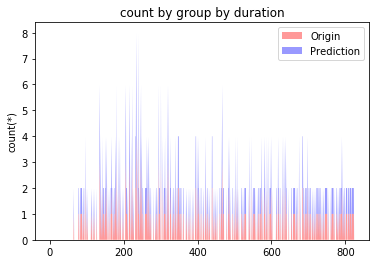

In [41]:
final_group_age=final_result.groupBy(final_result['duration'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_age,'duration')

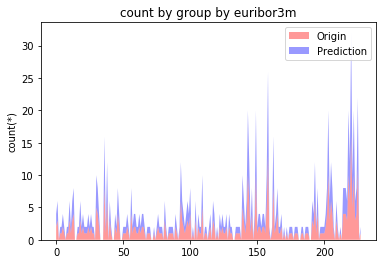

In [42]:
final_group_emp=final_result.groupBy(final_result['euribor3m'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'euribor3m')

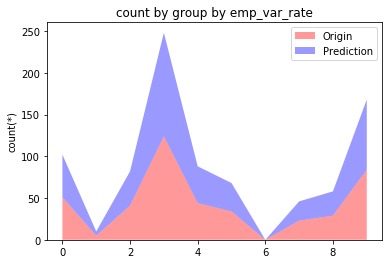

In [43]:
final_group_emp=final_result.groupBy(final_result['emp_var_rate'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'emp_var_rate')

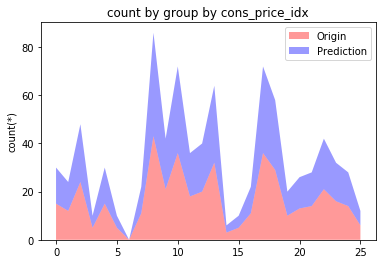

In [44]:
final_group_emp=final_result.groupBy(final_result['cons_price_idx'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()
showLines_bars2(final_group_emp,'cons_price_idx')

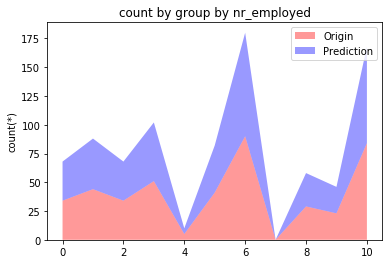

In [45]:
final_group_emp=final_result.groupBy(final_result['nr_employed'].alias("x")).agg(sum("d_y").alias("Origin_Yes_Count"),sum("final_prediction").alias("Prediction_Yes_Count")).sort("x").toPandas()  
showLines_bars2(final_group_emp,'nr_employed')

In [46]:
final_compare=final_result.groupBy("d_y","final_prediction").agg(count("age").alias("record_count")).sort("d_y","final_prediction")
final_compare =final_compare.withColumn("Y-N",when(((col('d_y')==1 )& (col('final_prediction')==1.0)) ,'Yes-Yes').otherwise(when(((col('d_y')==1)& (col('final_prediction')==0.0 ) ),'Yes-No').otherwise(when(col('final_prediction')==1.0,'No-Yes').otherwise('No-No'))))
final_compare=final_compare.toPandas()

In [47]:
ttl_recordCount=final_result.count()

In [48]:
final_compare["ratio"]=final_compare["record_count"]*100.0/ttl_recordCount

In [49]:
final_compare

,d_y,final_prediction,record_count,Y-N,ratio
0,0,0.0,2636,No-No,67.815796
1,0,1.0,816,No-Yes,20.993054
2,1,0.0,20,Yes-No,0.514536
3,1,1.0,415,Yes-Yes,10.676614


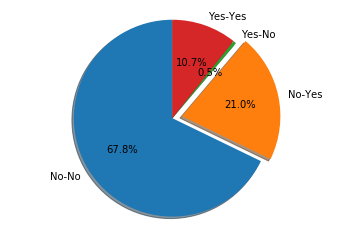

In [50]:
 

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =final_compare["Y-N"].values.tolist()
sizes = final_compare["ratio"].values.tolist()
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()